# Object Detection Tutorial

<table align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/georgia-tech-db/eva/blob/master/tutorials/02-object-detection.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" /> Run on Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/georgia-tech-db/eva/blob/master/tutorials/02-object-detection.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" /> View source on GitHub</a>
  </td>
  <td>
    <a target="_blank" href="https://raw.githubusercontent.com/georgia-tech-db/eva/master/tutorials/02-object-detection.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" /> Download notebook</a>
  </td>
</table>

### Start EVA server

We are reusing the start server notebook for launching the EVA server.

In [1]:
#!wget -nc "https://raw.githubusercontent.com/georgia-tech-db/eva/master/tutorials/00-start-eva-server.ipynb"
%run 00-start-eva-server.ipynb
cursor = connect_to_server()

rm: nohup.out: No such file or directory
cat: nohup.out: No such file or directory
22/11/27 13:23:57 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
11-27-2022 13:24:02 WARNING[create_udf_executor:create_udf_executor.py:exec:0042] UDF Array_Count already exists, nothing added.
11-27-2022 13:24:02 WARNING[create_udf_executor:create_udf_executor.py:exec:0042] UDF Crop already exists, nothing added.
11-27-2022 13:24:02 WARNING[create_udf_executor:create_udf_executor.py:exec:0042] UDF DummyObjectDetector already exists, nothing added.
11-27-2022 13:24:02 WARNING[create_udf_executor:create_udf_executor.py:exec:0042] UDF DummyMultiObjectDetector already exists, nothing added.
11-27-2022 13:24:02 CRITICAL[serve


[notice] A new release of pip available: 22.3 -> 22.3.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


### Getting the Video Files

In [2]:
# Getting the video files
!wget -nc https://www.dropbox.com/s/ljx2ejva1aztumg/1.mp4
# Getting the FastRCNN object detector
#!wget -nc https://raw.githubusercontent.com/georgia-tech-db/eva/master/eva/udfs/fastrcnn_object_detector.py
import car_plate_detector
import ocr_extractor

File ‘1.mp4’ already there; not retrieving.



### Load the surveillance videos for analysis

In [3]:
cursor.execute('DROP TABLE ObjectDetectionVideos')
response = cursor.fetch_all()
print(response)
cursor.execute('LOAD FILE "1.mp4" INTO ObjectDetectionVideos;') # for other machines delete "/tutorials"
response = cursor.fetch_all()
print(response)

@status: 0
@batch: Batch Object:
@dataframe:                                                    0
0  Table Successfully dropped: ObjectDetectionVideos
@batch_size: 1
@identifier_column: None
@query_time: 0.027036467000000286
@status: 0
@batch: Batch Object:
@dataframe:                                              0
0  Video successfully added at location: 1.mp4
@batch_size: 1
@identifier_column: None
@query_time: 0.05713246899999902


11-27-2022 13:24:07 ERROR [drop_executor:drop_executor.py:exec:0059] Failed to drop TABLE REF:: ( ObjectDetectionVideos SAMPLE FREQUENCY None)
NoneType: None


### Visualize Video

In [4]:
from ipywidgets import Video
Video.from_file("1.mp4", embed=True)

Video(value=b'\x00\x00\x00\x1cftypmp42\x00\x00\x00\x01isommp41mp42\x00\x00\x00\x01mdat\x00\x00\x00\x00...')

In [5]:
cursor.execute("DROP UDF CarPlateDetector;")
response = cursor.fetch_all()
print(response)

@status: 0
@batch: Batch Object:
@dataframe:                                            0
0  UDF CarPlateDetector successfully dropped
@batch_size: 1
@identifier_column: None
@query_time: 0.009383250999999149


### Optional - Register FasterRCNN (object detection) model into EVA 

#### Syntax
  
  `CREATE UDF [ IF NOT EXISTS ] <name> 
      INPUT  ( [ <arg_name> <arg_data_type> ] [ , ... ] )
      OUTPUT ( [ <result_name> <result_data_type> ] [ , ... ] )
      TYPE  <udf_type_name>
      IMPL  '<path_to_implementation>'`

#### Required Parameters
`<name>` - specifies the unique identifier for the UDF.

`[ <arg_name> <arg_data_type> ] [ , ... ]` - specifies the name and data type of the udf input arguments. Name is kept for consistency (ignored by eva right now), arguments data type is required. `ANYDIM` means the shape is inferred at runtime.

`[ <result_name> <result_data_type> ] [ , ... ]` - specifies the name and data type of the udf output arguments. 
Users can access a specific output of the UDF similar to access a column of a table. Eg. `<name>.<result_name>` 

`<udf_type_name>` - specifies the identifier for the type of the UDF. UDFs of the same type are assumed to be interchangeable. They should all have identical input and output arguments. For example, object classification can be one type. 

`<path_to_implementation>` - specifies the path to the implementation class for the UDF

In [6]:
cursor.execute("""CREATE UDF IF NOT EXISTS CarPlateDetector
      INPUT  (frame NDARRAY UINT8(3, ANYDIM, ANYDIM))
      OUTPUT (results NDARRAY FLOAT32(ANYDIM, ANYDIM))
      TYPE  Classification
      IMPL  'car_plate_detector.py';
      """) # for other machines delete "tutorials/"
response = cursor.fetch_all()
print(response)

@status: 0
@batch: Batch Object:
@dataframe:                                                    0
0  UDF CarPlateDetector successfully added to the...
@batch_size: 1
@identifier_column: None
@query_time: 1.8600439380000005


### Run Object detector on the video

In [7]:
cursor.execute("""SELECT id, CarPlateDetector(data)
                  FROM ObjectDetectionVideos 
                  WHERE id < 1""")
response = cursor.fetch_all()
print(response)

@status: 0
@batch: Batch Object:
@dataframe:    objectdetectionvideos.id                           carplatedetector.results
0                         0  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...
@batch_size: 1
@identifier_column: None
@query_time: 250.98949268300004


### Visualize output of Object detector on the video

In [8]:
import cv2
import numpy as np
def image_resize(image, width=None, height=None, inter=cv2.INTER_CUBIC):
    # https://stackoverflow.com/questions/44650888/resize-an-image-without-distortion-opencv
    dim = None
    (h, w) = image.shape[:2]

    if width is None and height is None:
        return image

    if width is None:
        r = height / float(h)
        dim = (int(w * r), height)
    else:
        r = width / float(w)
        dim = (width, int(h * r))

    resized = cv2.resize(image, dim, interpolation=inter)

    return resized

In [9]:
def unsharp_mask(image, kernel_size=(5, 5), sigma=1.0, amount=1.0, threshold=0):
    # https://stackoverflow.com/questions/4993082/how-to-sharpen-an-image-in-opencv
    blurred = cv2.GaussianBlur(image, kernel_size, sigma)
    sharpened = float(amount + 1) * image - float(amount) * blurred
    sharpened = np.maximum(sharpened, np.zeros(sharpened.shape))
    sharpened = np.minimum(sharpened, 255 * np.ones(sharpened.shape))
    sharpened = sharpened.round().astype(np.uint8)
    if threshold > 0:
        low_contrast_mask = np.absolute(image - blurred) < threshold
        np.copyto(sharpened, image, where=low_contrast_mask)
    return sharpened

In [10]:
def show_images(images, cols=1, prefix='Image ', titles=None):
    # https://gist.github.com/soply/f3eec2e79c165e39c9d540e916142ae1
    assert((titles is None)or (len(images) == len(titles)))
    n_images = len(images)
    if titles is None:
        titles = [f'{prefix} ({i})' for i in range(1, n_images + 1)]
    fig = plt.figure()
    for n, (image, title) in enumerate(zip(images, titles)):
        a = fig.add_subplot(cols, int(np.ceil(n_images/float(cols))), n + 1)
        if image.ndim == 2:
            plt.gray()
        plt.imshow(image)
        a.set_title(title)
    fig.set_size_inches(np.array(fig.get_size_inches()) * n_images)
    plt.show()

In [11]:
def remove_noise(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]

    # Morph open to remove noise
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (2,2))
    opening = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel, iterations=1)

    # Find contours and remove small noise
    cnts = cv2.findContours(opening, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = cnts[0] if len(cnts) == 2 else cnts[1]
    for c in cnts:
        area = cv2.contourArea(c)
        if area < 200:
            cv2.drawContours(opening, [c], -1, 0, -1)

    # Invert and apply slight Gaussian blur
    result = 255 - opening
    #result = cv2.GaussianBlur(result, (3,3), 0)
    return result

In [12]:
from pprint import pprint
from matplotlib import pyplot as plt

def annotate_video(detections, input_video_path):
    color1=(207, 248, 64)
    color2=(255, 49, 49)
    thickness=4

    vcap = cv2.VideoCapture(input_video_path)
    width = int(vcap.get(3))
    height = int(vcap.get(4))


    frame_id = 0
    # Capture frame-by-frame
    # ret = 1 if the video is captured; frame is the image
    ret, frame = vcap.read()
    car_plates = []

    while ret:
        df = detections
        df = df[['carplatedetector.results']][df.index == frame_id]
        if df.size:
            dfList = df.values.tolist()
            mask = np.array(dfList[0][0])
            mask = mask.astype(np.uint8)
            #plt.imshow(mask)
            #frame = cv2.cvtColor(np.array(frame, copy=True), cv2.COLOR_RGB2BGR)
            contours, hierarchy = cv2.findContours(
                mask, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
            plates = []

            for j, c in enumerate(contours):
                x,y,w,h = cv2.boundingRect(c)
                plate = frame[y:y+h, x:x+w]
                # resize_height = 256
                # plate = image_resize(
                #      plate, height= resize_height)
                #
                # sharpen_amount = 50
                # plate = unsharp_mask(plate, amount=sharpen_amount)
                # plate = cv2.cvtColor(np.array(plate), cv2.COLOR_BGR2RGB)
                # #plate = remove_noise(plate)
                #plate = cv2.fastNlMeansDenoisingColored(plate,None,20,10,7,21)
                fourcc = cv2.VideoWriter_fourcc('m', 'p', '4', 'v')
                fps = 25
                dim = plate.shape[:2]
                video = cv2.VideoWriter("frame" + str(frame_id)+ "_plate" + str(j) + ".mp4", fourcc, fps, (dim[1], dim[0]))
                for _ in range(50): video.write(plate)
                video.release()
                plates.append(plate)
                """
                x1, y1, x2, y2 = bbox
                x1, y1, x2, y2 = int(x1), int(y1), int(x2), int(y2)
                # object bbox
                img=cv2.rectangle(frame, (x1, y1), (x2, y2), color1, thickness) 
                # object label
                cv2.putText(img, label, (x1, y1-10), cv2.FONT_HERSHEY_SIMPLEX, 10, color1, thickness) 
                # frame label
                cv2.putText(img, 'Frame ID: ' + str(frame_id), (700, 500), cv2.FONT_HERSHEY_SIMPLEX, 1.2, color2, thickness)
                if label == "car": car_positions.append(bbox) 
            video.write(img)
                """
                if frame_id % 5 == 0:
                    plt.imshow(plate)
                    plt.show()
            # show_images(plates,  prefix='License plate')
            car_plates.append(plates)
        frame_id+=1
        ret, frame = vcap.read()
    return car_plates

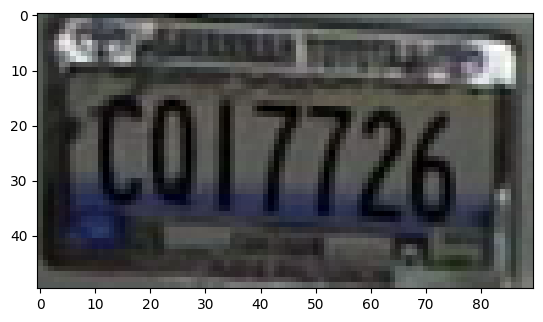

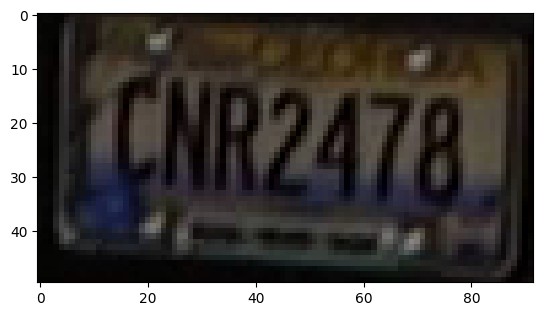

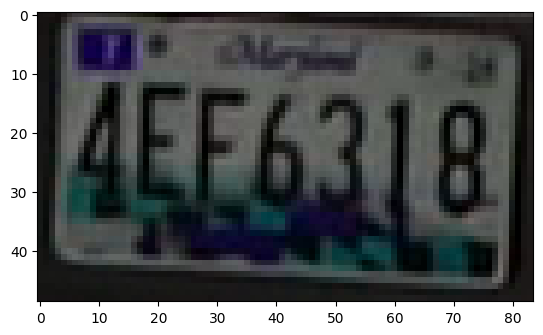

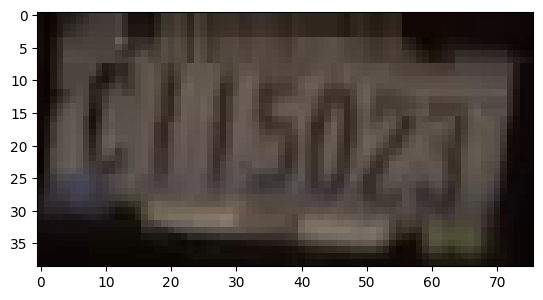

In [13]:
from ipywidgets import Video, Image
input_path = "1.mp4"
dataframe = response.batch.frames
car_plates = annotate_video(dataframe, input_path)

In [14]:
from PIL import Image
def plates2videos(car_plates):
    for i, plates in enumerate(car_plates):
        for j, plate in enumerate(plates):
            fourcc = cv2.VideoWriter_fourcc('m', 'p', '4', 'v')
            fps = 25
            dim = plate.shape[:2]
            video = cv2.VideoWriter("frame" + str(i)+ "_plate" + str(j) + ".mp4", fourcc, fps, (dim[1], dim[0]))
            plate = cv2.cvtColor(plate, cv2.COLOR_RGB2BGR)
            for _ in range(50): video.write(plate)
            video.release()

In [15]:
plates2videos(car_plates)

In [16]:
cursor.execute("DROP UDF OCRExtractor;")
response = cursor.fetch_all()
print(response)

@status: 0
@batch: Batch Object:
@dataframe:                                        0
0  UDF OCRExtractor successfully dropped
@batch_size: 1
@identifier_column: None
@query_time: 0.009862397999995665


In [17]:
cursor.execute("""CREATE UDF IF NOT EXISTS OCRExtractor
      INPUT  (frame NDARRAY UINT8(3, ANYDIM, ANYDIM))
      OUTPUT (labels NDARRAY STR(ANYDIM), bboxes NDARRAY FLOAT32(ANYDIM, 4),
                scores NDARRAY FLOAT32(ANYDIM))
      TYPE  Classification
      IMPL  'ocr_extractor.py';
      """)
response = cursor.fetch_all()
print(response)

CUDA not available - defaulting to CPU. Note: This module is much faster with a GPU.


@status: 0
@batch: Batch Object:
@dataframe:                                                    0
0  UDF OCRExtractor successfully added to the dat...
@batch_size: 1
@identifier_column: None
@query_time: 3.012745841000026


In [18]:
for i, plates in enumerate(car_plates):
    for j, plate in enumerate(plates):
        file_name = "frame" + str(i)+ "_plate" + str(j) + ".mp4"
        cursor.execute('DROP TABLE ObjectDetectionVideos')
        response = cursor.fetch_all()
        print(response)
        cursor.execute('LOAD FILE "' + file_name + '" INTO ObjectDetectionVideos;')
        response = cursor.fetch_all()
        print(response)
        cursor.execute("""SELECT id, OCRExtractor(data)
                      FROM ObjectDetectionVideos
                      WHERE id < 1""")
        response = cursor.fetch_all()
        print(response)

@status: 0
@batch: Batch Object:
@dataframe:                                                    0
0  Table Successfully dropped: ObjectDetectionVideos
@batch_size: 1
@identifier_column: None
@query_time: 0.012842844999966019
@status: 0
@batch: Batch Object:
@dataframe:                                                    0
0  Video successfully added at location: frame0_p...
@batch_size: 1
@identifier_column: None
@query_time: 0.04636236599998256


11-27-2022 13:28:37 ERROR [drop_executor:drop_executor.py:exec:0059] Failed to drop TABLE REF:: ( ObjectDetectionVideos SAMPLE FREQUENCY None)
NoneType: None
CUDA not available - defaulting to CPU. Note: This module is much faster with a GPU.


@status: 0
@batch: Batch Object:
@dataframe:    objectdetectionvideos.id ocrextractor.labels  \
0                         0         [[c017726]]   

                      ocrextractor.bboxes    ocrextractor.scores  
0  [[[0, 7], [84, 7], [84, 46], [0, 46]]]  [0.15757733200000001]  
@batch_size: 1
@identifier_column: None
@query_time: 2.3082844730000147
@status: 0
@batch: Batch Object:
@dataframe:                                                    0
0  Table Successfully dropped: ObjectDetectionVideos
@batch_size: 1
@identifier_column: None
@query_time: 0.010838301000035244
@status: 0
@batch: Batch Object:
@dataframe:                                                    0
0  Video successfully added at location: frame0_p...
@batch_size: 1
@identifier_column: None
@query_time: 0.041548519999992095


11-27-2022 13:28:39 ERROR [drop_executor:drop_executor.py:exec:0059] Failed to drop TABLE REF:: ( ObjectDetectionVideos SAMPLE FREQUENCY None)
NoneType: None
CUDA not available - defaulting to CPU. Note: This module is much faster with a GPU.


@status: 0
@batch: Batch Object:
@dataframe:    objectdetectionvideos.id ocrextractor.labels  \
0                         0          [(4R247e ]   

                      ocrextractor.bboxes     ocrextractor.scores  
0  [[[7, 3], [88, 3], [88, 44], [7, 44]]]  [0.058005174400000005]  
@batch_size: 1
@identifier_column: None
@query_time: 2.3228481990000205
@status: 0
@batch: Batch Object:
@dataframe:                                                    0
0  Table Successfully dropped: ObjectDetectionVideos
@batch_size: 1
@identifier_column: None
@query_time: 0.011445352999999159
@status: 0
@batch: Batch Object:
@dataframe:                                                    0
0  Video successfully added at location: frame0_p...
@batch_size: 1
@identifier_column: None
@query_time: 0.0400211630000058


11-27-2022 13:28:42 ERROR [drop_executor:drop_executor.py:exec:0059] Failed to drop TABLE REF:: ( ObjectDetectionVideos SAMPLE FREQUENCY None)
NoneType: None
CUDA not available - defaulting to CPU. Note: This module is much faster with a GPU.


@status: 0
@batch: Batch Object:
@dataframe:    objectdetectionvideos.id ocrextractor.labels  \
0                         0          [aeF631e]]   

                      ocrextractor.bboxes ocrextractor.scores  
0  [[[0, 5], [84, 5], [84, 42], [0, 42]]]      [0.2139060151]  
@batch_size: 1
@identifier_column: None
@query_time: 2.309961090999991
@status: 0
@batch: Batch Object:
@dataframe:                                                    0
0  Table Successfully dropped: ObjectDetectionVideos
@batch_size: 1
@identifier_column: None
@query_time: 0.010987046999957784
@status: 0
@batch: Batch Object:
@dataframe:                                                    0
0  Video successfully added at location: frame0_p...
@batch_size: 1
@identifier_column: None
@query_time: 0.04655595699995274


11-27-2022 13:28:44 ERROR [drop_executor:drop_executor.py:exec:0059] Failed to drop TABLE REF:: ( ObjectDetectionVideos SAMPLE FREQUENCY None)
NoneType: None
CUDA not available - defaulting to CPU. Note: This module is much faster with a GPU.


@status: 0
@batch: Batch Object:
@dataframe:    objectdetectionvideos.id ocrextractor.labels  \
0                         0                [OL]   

                                 ocrextractor.bboxes    ocrextractor.scores  
0  [[[1.1758366163, -0.8845718429], [74.900701075...  [0.15800174220000002]  
@batch_size: 1
@identifier_column: None
@query_time: 2.2996661550000113


In [19]:
# cursor.execute("""CREATE UDF IF NOT EXISTS OCRExtractor
#       INPUT  (frame NDARRAY UINT8(3, ANYDIM, ANYDIM))
#       OUTPUT (labels NDARRAY STR(ANYDIM), bboxes NDARRAY FLOAT32(ANYDIM, 4),
#                 scores NDARRAY FLOAT32(ANYDIM))
#       TYPE  Classification
#       IMPL  'tutorials/ocr_extractor.py';
#       """)
# response = cursor.fetch_all()
# print(response)

In [ ]:
# write to file 


In [21]:
import cv2
from pprint import pprint
from matplotlib import pyplot as plt

def annotate_video_ocr(detections, input_video_path, output_video_path):
    color1=(0, 255, 150)
    color2=(255, 49, 49)
    thickness=4

    vcap = cv2.VideoCapture(input_video_path)
    width = int(vcap.get(3))
    height = int(vcap.get(4))
    fps = vcap.get(5)
    fourcc = cv2.VideoWriter_fourcc('m', 'p', '4', 'v') #codec
    video=cv2.VideoWriter(output_video_path, fourcc, fps, (width,height))

    frame_id = 0
    # Capture frame-by-frame
    # ret = 1 if the video is captured; frame is the image
    ret, frame = vcap.read() 

    while ret:
        df = detections
        df = df[['ocrextractor.bboxes', 'ocrextractor.labels']][df.index == frame_id]
        if df.size:
            dfLst = df.values.tolist()
            for bbox, label in zip(dfLst[0][0], dfLst[0][1]):
                x1, y1, x2, y2 = bbox
                x1, y1, x2, y2 = int(x1[0]), int(x1[1]), int(x2[0]), int(x2[1])
                # object bbox
                img=cv2.rectangle(frame, (x1, y1), (x2, y2), color1, thickness) 
                # object label
                cv2.putText(img, label, (x1, y1-10), cv2.FONT_HERSHEY_SIMPLEX, 1.5, color1, thickness) 
                # frame label
                cv2.putText(img, 'Frame ID: ' + str(frame_id), (30, 400), cv2.FONT_HERSHEY_SIMPLEX, 1, color2, thickness) 
            video.write(img)

            # Show every fifth frame
            if frame_id % 2 == 0:
                plt.imshow(img)
                plt.show()
        
        frame_id+=1
        ret, frame = vcap.read()

    video.release()
    vcap.release()

In [25]:
from ipywidgets import Video, Image
input_path = 'frame0_plate1.mp4'
output_path = 'frame0_plate1.mp4'

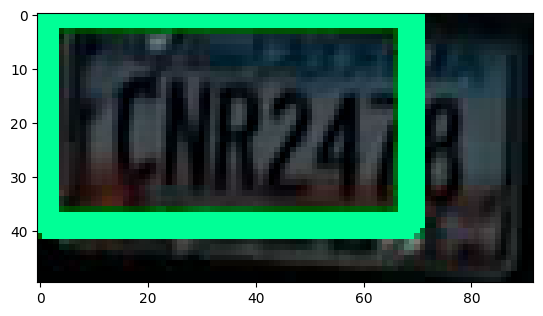

Video(value=b'\x00\x00\x00\x1cftypisom\x00\x00\x02\x00isomiso2mp41\x00\x00\x00\x08free\x00\x00\x07\x07...')

: 

In [26]:
dataframe = response.batch.frames
annotate_video_ocr(dataframe, input_path, output_path)
Video.from_file(output_path)

In [22]:
cursor.execute("DROP UDF FastRCNNObjectDetector;")
response = cursor.fetch_all()
print(response)

@status: 0
@batch: Batch Object:
@dataframe:                                                  0
0  UDF FastRCNNObjectDetector successfully dropped
@batch_size: 1
@identifier_column: None
@query_time: 0.008555150000006506


### Dropping a udf
simply enter command `drop udf udf_name`

In [21]:
cursor.execute("DROP UDF FastRCNNObjectDetector;")
response = cursor.fetch_all()
print(response)

@status: -1
@batch: None
@error: UDF FastRCNNObjectDetector does not exist, therefore cannot be dropped.


11-26-2022 21:39:47 ERROR [drop_udf_executor:drop_udf_executor.py:exec:0046] UDF FastRCNNObjectDetector does not exist, therefore cannot be dropped.
NoneType: None
11-26-2022 21:39:47 WARNING[command_handler:command_handler.py:handle_request:0075] UDF FastRCNNObjectDetector does not exist, therefore cannot be dropped.


### Dropping a udf
simply enter command `drop udf udf_name`

In [22]:
cursor.execute("DROP UDF FastRCNNObjectDetector;")
response = cursor.fetch_all()
print(response)

@status: -1
@batch: None
@error: UDF FastRCNNObjectDetector does not exist, therefore cannot be dropped.


11-26-2022 21:39:47 ERROR [drop_udf_executor:drop_udf_executor.py:exec:0046] UDF FastRCNNObjectDetector does not exist, therefore cannot be dropped.
NoneType: None
11-26-2022 21:39:47 WARNING[command_handler:command_handler.py:handle_request:0075] UDF FastRCNNObjectDetector does not exist, therefore cannot be dropped.
